In [1]:
from transient_piezo_truss import * 
import matplotlib.pyplot as plt 

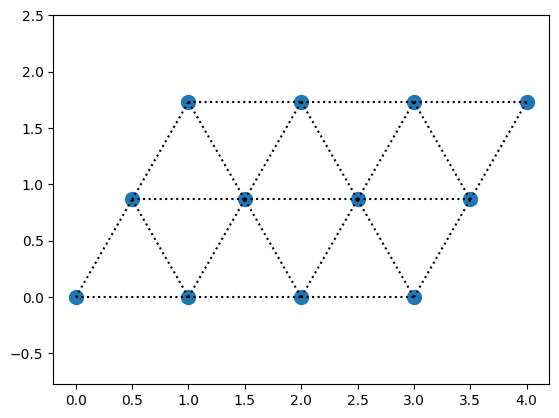

=== Q_Error:5.8024e-07 ===: 100%|██████████| 25/25 [03:50<00:00,  9.22s/it]


In [2]:
# Create a static_piezo_truss object
M, N = 4, 3
freq = [5, 10, 15]
transient_piezo_truss = TransientPiezoTruss(size=(M, N), freq=freq)
# Plot the structure
transient_piezo_truss.plotStructure()
#
UNodes_free = [0, 1, 2*M-1]
u_free = [  [[0, 0], [0, 0], [0, 0]], 
            [[0, 0], [0, 0], [0, 0]], 
            [[0, 0], [0, 0], [0, 0]]]
#
UNodes_clamped = [0, 1, 2*M-1, -2, -1]
u_clamped = [   [[0, 0], [0, 0], [0, 0]], 
                [[0, 0], [0, 0], [0, 0]], 
                [[0, 0], [0, 0], [0, 0]],
                [[1E-7, 2E-7], [5E-8, 0], [0, 1.5E-7]], 
                [[.5E-7, 1.5E-7], [0, 0], [.5E-7, 0]]]
#
T = np.linspace(0, 1, 1000)
N = len(T) // 2
Vol = np.ones((len(transient_piezo_truss.edges), len(freq), 2)) * 10
#
Epoch = 25
lr = 1E9
err = 10.
# Vol = np.ones((len(transient_piezo_truss.edges), len(freq), 2)) * 10
pbar = tqdm.tqdm(range(Epoch))
for i in pbar:
    #
    pbar.set_description("=== Q_Error:{:.4e} ===".format(err))
    #
    transient_piezo_truss.solve(T, UNodes_free, u_free, V=Vol)
    Q_free = transient_piezo_truss.calQ.copy()
    #
    transient_piezo_truss.solve(T, UNodes_clamped, u_clamped, V=Vol)
    Q_clamped = transient_piezo_truss.calQ.copy()
    #
    for n, fq in enumerate(freq):
        Q_free_sin = 2 * Q_free[:, N:] @ np.sin(fq * 2 * np.pi * T[N:]) / len(T[N:])
        Q_free_cos = 2 * Q_free[:, N:] @ np.cos(fq * 2 * np.pi * T[N:]) / len(T[N:])
        #
        Q_clamped_sin = 2 * Q_clamped[:, N:] @ np.sin(fq * 2 * np.pi * T[N:]) / len(T[N:])
        Q_clamped_cos = 2 * Q_clamped[:, N:] @ np.cos(fq * 2 * np.pi * T[N:]) / len(T[N:])
        #
        Vol[:, n, 0] += lr * (Q_clamped_sin - Q_free_sin)
        Vol[:, n, 1] += lr * (Q_clamped_cos - Q_free_cos)
    #
    err = np.linalg.norm((Q_free-Q_clamped)[:, N:]) / np.linalg.norm(Q_free[:, N:])
    
    # print(err)

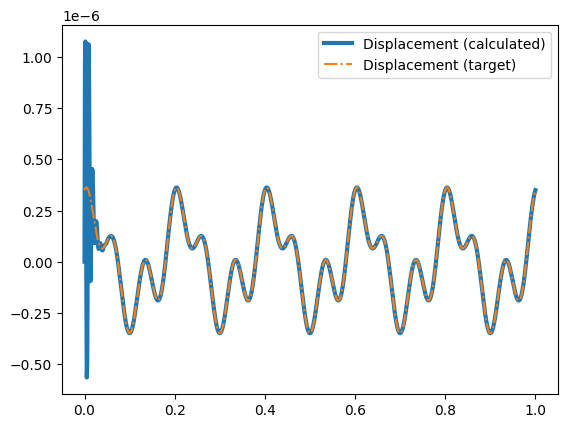

In [3]:
# Define error in tqdm 
#
import matplotlib.pyplot as plt 
#
transient_piezo_truss.solve(T, UNodes_free, u_free, V=Vol)
plt.plot(T, transient_piezo_truss.calDisp[-1, 0, :], label="Displacement (calculated)", linewidth=3)
transient_piezo_truss.solve(T, UNodes_clamped, u_clamped, V=Vol)
plt.plot(T, transient_piezo_truss.calDisp[-1, 0, :], label="Displacement (target)", linestyle="-.")
plt.legend()
plt.show()